In [1]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, TimeDistributed # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint # type: ignore
from gtts import gTTS
import IPython.display as ipd

In [2]:
# Dummy texts for demonstration purposes
texts = [
    "Hello, this is a test.",
    "This is another test.",
    "Deep learning is fascinating."
]

In [3]:
# Tokenize the texts
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
input_sequences = pad_sequences(sequences, padding='post')

In [4]:
# Print shapes for debugging
print("Input sequences shape:", input_sequences.shape)

Input sequences shape: (3, 29)


In [5]:
#Preprocessing audio files to spectrograms
def preprocess_audio(file_path):
    y, sr = librosa.load(file_path)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram.T  # Transpose to have time on the first axis

audio_files = [
    "C:\\Users\\DELL\\Desktop\\text -to-speech\\03-01-01-01-01-01-01.wav",
    "C:\\Users\\DELL\\Desktop\\text -to-speech\\03-01-01-01-01-02-01.wav",
    "C:\\Users\\DELL\\Desktop\\text -to-speech\\03-01-04-02-02-02-01.wav"
]

spectrograms = [preprocess_audio(file) for file in audio_files]


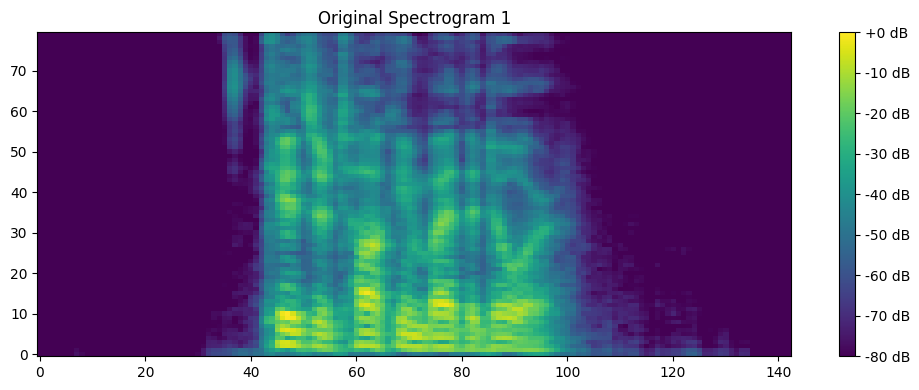

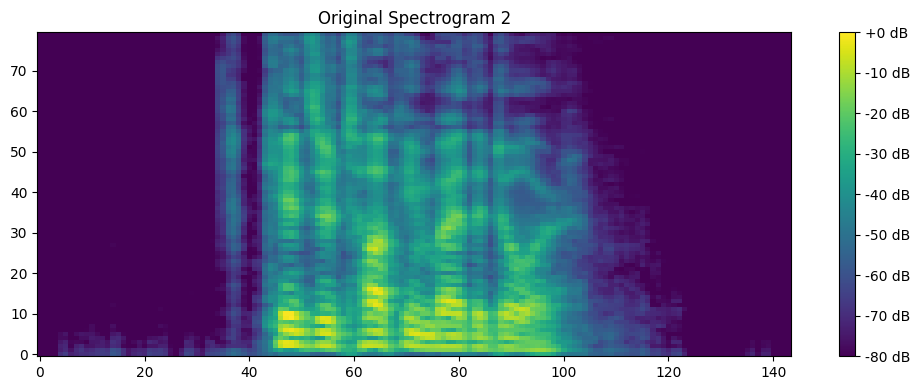

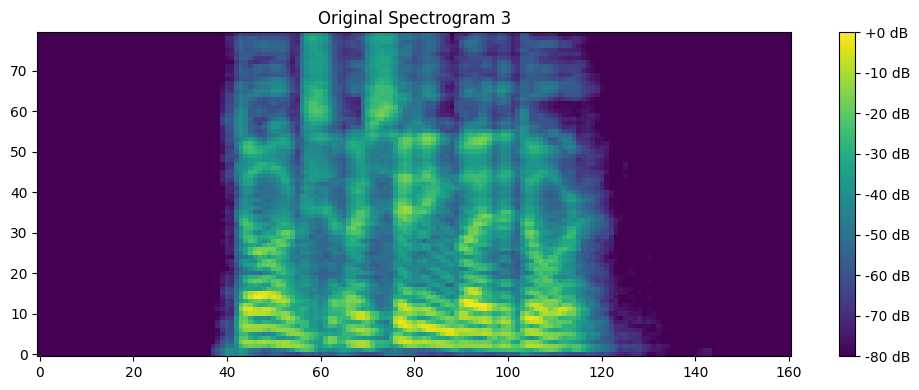

In [6]:
# Plot original spectrograms
for i, spectrogram in enumerate(spectrograms):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    plt.title(f'Original Spectrogram {i+1}')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

In [7]:
# Ensure all spectrograms have the same length (for simplicity)
max_spectrogram_length = max(s.shape[0] for s in spectrograms)
padded_spectrograms = [np.pad(s, ((0, max_spectrogram_length - s.shape[0]), (0, 0)), mode='constant') for s in spectrograms]
target_data = np.array(padded_spectrograms)

print("Target spectrograms shape:", target_data.shape)


Target spectrograms shape: (3, 161, 80)


In [8]:
# Pad input sequences to match the length of target data
input_length = target_data.shape[1]
input_sequences = pad_sequences(sequences, maxlen=input_length, padding='post')

print("Padded input sequences shape:", input_sequences.shape)


Padded input sequences shape: (3, 161)


In [9]:
# Define the model
def build_model(input_dim, output_dim, input_length, units):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=input_dim, output_dim=units, input_length=input_length)(inputs)
    x = LSTM(units, return_sequences=True)(x)
    x = LSTM(units, return_sequences=True)(x)
    outputs = TimeDistributed(Dense(output_dim))(x)
    model = Model(inputs, outputs)
    return model

input_dim = len(tokenizer.word_index) + 1
output_dim = target_data.shape[2]  # Number of spectrogram frequency bins
units = 256

model = build_model(input_dim, output_dim,input_length, units)
model.compile(optimizer=Adam(), loss='mean_squared_error')


C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [10]:
# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 161)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 161, 256)       │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 161, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 161, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 161, 80)        │        20,560 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,076,048 (4.10 MB)

 Trainable params: 1,076,048 (4.10 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Training the model
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'model.keras')
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='loss')
history = model.fit(input_sequences, target_data, epochs=10, callbacks=[checkpoint])

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - loss: 4058.9133
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 4054.9460
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 4043.3191
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 4011.3567   
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 3974.0637   
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 3938.5144   
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 3901.1672   
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 3863.2053   
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 3824.6868   
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 3786.2859   


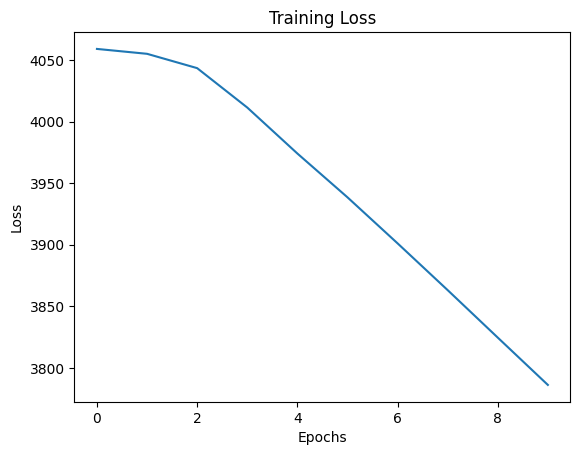

In [12]:
# Visualize training loss
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [13]:
# Text-to-speech conversion function
def spectrogram_to_waveform(spectrogram):
    spectrogram = spectrogram.T  # Transpose to have time on the first axis
    exp_spectrogram = librosa.db_to_power(spectrogram)
    y = librosa.feature.inverse.mel_to_audio(exp_spectrogram, sr=22050)
    return y

def text_to_speech(model, tokenizer, text):
    sequence = tokenizer.texts_to_sequences([text])
    sequence = pad_sequences(sequence, maxlen=input_length, padding='post')
    spectrogram = model.predict(sequence)
    waveform = spectrogram_to_waveform(spectrogram[0])
    # Plot the generated spectrogram
    plt.imshow(spectrogram[0].T, aspect='auto', origin='lower')
    plt.title('Generated Spectrogram')
    plt.show()

    # Play the waveform
    return ipd.Audio(waveform, rate=22050)

In [14]:
# Function to convert text to speech in the specified language
def text_to_speech(text, lang='en', filename='output.mp3'):
    tts = gTTS(text=text, lang=lang)
    tts.save(filename)
    print(f"Audio saved as {filename} in language: {lang}")

In [15]:
# Examples of converting text to speech in different languages
text_to_speech("She likes to travel to new places.", lang='en', filename='output_en.mp3')  # English
text_to_speech("A ella le gusta viajar a lugares nuevos.", lang='es', filename='output_es.mp3')  # Spanish
text_to_speech("Elle aime voyager vers de nouveaux endroits.", lang='fr', filename='output_fr.mp3')  # French
text_to_speech("उसे नए जगहों पर यात्रा करना पसंद है।", lang='hi', filename='output_hi.mp3')  # Hindi

Audio saved as output_en.mp3 in language: en
Audio saved as output_es.mp3 in language: es
Audio saved as output_fr.mp3 in language: fr
Audio saved as output_hi.mp3 in language: hi


In [16]:

print("Playing English audio:")
ipd.display(ipd.Audio('output_en.mp3'))

print("Playing Spanish audio:")
ipd.display(ipd.Audio('output_es.mp3'))

print("Playing French audio:")
ipd.display(ipd.Audio('output_fr.mp3'))

print("Playing Hindi audio:")
ipd.display(ipd.Audio('output_hi.mp3'))

Playing English audio:


Playing Spanish audio:


Playing French audio:


Playing Hindi audio:
